In [1]:
import numpy as np
import pandas as pd 
import pandas_ta as ta
import yfinance as yf
import sqlite3 

* DX-Y.NYB: US Dollar Index
* ^VIX: CBOE Volatility Index

In [2]:
conn = sqlite3.connect("../database.db")
stock_df = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = '^GSPC'", con=conn)
stock_df = stock_df.drop(columns=["ID", "Volume", "Ticker", "InsertTime"])
# stock_df = stock_df.set_index("Datetime")

stock_df

,Datetime,Open,High,Low,Close
0,2016-02-16 00:00:00.000000,1871.439941,1895.770020,1871.439941,1895.579956
1,2016-02-17 00:00:00.000000,1898.800049,1930.680054,1898.800049,1926.819946
2,2016-02-18 00:00:00.000000,1927.569946,1930.000000,1915.089966,1917.829956
3,2016-02-19 00:00:00.000000,1916.739990,1918.780029,1902.170044,1917.780029
4,2016-02-22 00:00:00.000000,1924.439941,1946.699951,1924.439941,1945.500000
...,...,...,...,...,...
2509,2026-02-06 00:00:00.000000,6816.740234,6944.890137,6816.740234,6932.299805
2510,2026-02-09 00:00:00.000000,6917.259766,6980.100098,6905.870117,6964.819824
2511,2026-02-10 00:00:00.000000,6974.490234,6986.830078,6937.529785,6941.810059
2512,2026-02-11 00:00:00.000000,6976.479980,6993.479980,6911.970215,6941.470215


### Denoising the data

I don't want this model to have lookahead bias, so I start by defining train, validation, and testing `dfs`. 

"We have applied the soft mode of the Haar wavelets using python library scikit-image to denoise the close price of the index." (page 15)

In [3]:
from skimage.restoration import denoise_wavelet, estimate_sigma

train_size=2000
val_size=250

cols = stock_df.shape[1]

sigmas = []
for i in range(cols):
    if i == 0:
        sigmas.append(0)
    else:
        inner_sigma = estimate_sigma(stock_df.iloc[:train_size, i], channel_axis=None)
        sigmas.append(inner_sigma)

def denoise_df(df):
    inner_df = df.copy()

    train_df = inner_df.iloc[:train_size, :]
    val_df = inner_df.iloc[train_size:train_size+val_size, :]
    test_df = inner_df.iloc[train_size+val_size:, :]


    for i in range(cols):
        if i > 0:
            train_df.iloc[:, i] = denoise_wavelet(
                train_df.iloc[:, i],
                wavelet="haar", 
                mode="soft",
                sigma=sigmas[i],
                rescale_sigma=True,
                channel_axis=None
            )

            val_df.iloc[:, i] = denoise_wavelet(
                val_df.iloc[:, i],
                wavelet="haar", 
                mode="soft",
                sigma=sigmas[i],
                rescale_sigma=True,
                channel_axis=None
            )

            test_df.iloc[:, i] = denoise_wavelet(
                test_df.iloc[:, i],
                wavelet="haar", 
                mode="soft",
                sigma=sigmas[i],
                rescale_sigma=True,
                channel_axis=None
            )

    inner_df = pd.concat([train_df, val_df, test_df])

    return inner_df
# train_denoised, sigma = denoise_wavelet(
#     train_df, 
#     wavelet="haar",
#     mode="soft", 
#     rescale_sigma=True,
#     channel_axis=None,
#     sigma=None,
#     convert2ycbcr=False,
#     method="BayesShrink",
#     return_sigma=True
# )

In [4]:
stock_df = denoise_df(stock_df)

In [5]:
stock_df["Datetime"] = pd.to_datetime(stock_df["Datetime"])

stock_df["MACD"] = ta.macd(stock_df.Close).iloc[:, 0]
stock_df["ATR"] = ta.atr(stock_df.High, stock_df.Low, stock_df.Close)
stock_df["RSI"] = ta.rsi(stock_df.Close)


stock_df = stock_df.drop(columns=["High", "Low"])
stock_df = stock_df.dropna()
stock_df

,Datetime,Open,Close,MACD,ATR,RSI
25,2016-03-22,2046.471762,2048.887162,40.618064,20.966599,91.259153
26,2016-03-23,2044.470155,2039.080907,39.076284,20.684064,84.540371
27,2016-03-24,2042.177839,2039.080907,37.423024,20.130143,84.540371
28,2016-03-28,2037.903547,2043.572356,36.059553,19.917704,85.122213
29,2016-03-29,2037.903547,2050.701405,35.149071,19.990263,86.021496
...,...,...,...,...,...,...
2509,2026-02-06,6821.893120,6931.633951,5.319739,78.177272,52.225675
2510,2026-02-09,6921.458514,6960.081711,8.588181,77.946707,54.633275
2511,2026-02-10,6972.427792,6942.475913,9.646604,76.001761,52.857892
2512,2026-02-11,6971.327095,6939.820336,10.154079,76.339981,52.580339


In [6]:
unemployment = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'URATE'", con=conn)
inflation = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'IRATE'", con=conn)
consumer_sentiment = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'CSI'", con=conn)
usd_index = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = 'DX-Y.NYB'", con=conn)
cboe_vol = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = '^VIX'", con=conn) 

In [7]:
unemployment["Datetime"] = pd.to_datetime(unemployment["Datetime"])
inflation["Datetime"] = pd.to_datetime(inflation["Datetime"])
consumer_sentiment["Datetime"] = pd.to_datetime(consumer_sentiment["Datetime"])
usd_index["Datetime"] = pd.to_datetime(usd_index["Datetime"])
cboe_vol["Datetime"] = pd.to_datetime(cboe_vol["Datetime"])

In [8]:
len(unemployment), len(inflation), len(consumer_sentiment), len(usd_index), len(cboe_vol)

(121, 121, 121, 2515, 2515)

### Combining the data

In [9]:
import duckdb

In [10]:
df = duckdb.query(
"""
/*SELECT A.*, URATE, IRATE, CSI, USDX, CBOE FROM 
(

    SELECT * FROM stock_df

) AS A LEFT JOIN 
(
    SELECT Datetime, Rate AS 'URATE' FROM unemployment
) AS B ON A.Datetime = B.Datetime LEFT JOIN 
(
    SELECT Datetime, Rate AS 'IRATE' FROM inflation
) AS C ON A.Datetime = C.Datetime LEFT JOIN 
(
    SELECT Datetime, Rate AS 'CSI' FROM consumer_sentiment
) AS D ON A.Datetime = D.Datetime LEFT JOIN 
(
    SELECT Datetime, Close AS 'USDX' FROM usd_index
) AS E ON A.Datetime = E.Datetime LEFT JOIN 
(
    SELECT Datetime, Close AS 'CBOE' FROM cboe_vol
) AS F ON A.Datetime = F.Datetime*/

SELECT A.*, USDX, CBOE FROM 
(

    SELECT * FROM stock_df

) AS A LEFT JOIN 
(
    SELECT Datetime, Close AS 'USDX' FROM usd_index
) AS E ON A.Datetime = E.Datetime LEFT JOIN 
(
    SELECT Datetime, Close AS 'CBOE' FROM cboe_vol
) AS F ON A.Datetime = F.Datetime

"""
).to_df()

df = df.set_index("Datetime", drop=True)
df = df.sort_index()
df

,Open,Close,MACD,ATR,RSI,USDX,CBOE
Datetime,,,,,,,
2016-03-22,2046.471762,2048.887162,40.618064,20.966599,91.259153,95.650002,14.170000
2016-03-23,2044.470155,2039.080907,39.076284,20.684064,84.540371,96.050003,14.940000
2016-03-24,2042.177839,2039.080907,37.423024,20.130143,84.540371,96.139999,14.740000
2016-03-28,2037.903547,2043.572356,36.059553,19.917704,85.122213,95.940002,15.240000
2016-03-29,2037.903547,2050.701405,35.149071,19.990263,86.021496,95.160004,13.820000
...,...,...,...,...,...,...,...
2026-02-06,6821.893120,6931.633951,5.319739,78.177272,52.225675,97.629997,20.370001
2026-02-09,6921.458514,6960.081711,8.588181,77.946707,54.633275,96.820000,17.360001
2026-02-10,6972.427792,6942.475913,9.646604,76.001761,52.857892,96.800003,17.790001


In [11]:
df = df.ffill()
df = df.bfill()
df

,Open,Close,MACD,ATR,RSI,USDX,CBOE
Datetime,,,,,,,
2016-03-22,2046.471762,2048.887162,40.618064,20.966599,91.259153,95.650002,14.170000
2016-03-23,2044.470155,2039.080907,39.076284,20.684064,84.540371,96.050003,14.940000
2016-03-24,2042.177839,2039.080907,37.423024,20.130143,84.540371,96.139999,14.740000
2016-03-28,2037.903547,2043.572356,36.059553,19.917704,85.122213,95.940002,15.240000
2016-03-29,2037.903547,2050.701405,35.149071,19.990263,86.021496,95.160004,13.820000
...,...,...,...,...,...,...,...
2026-02-06,6821.893120,6931.633951,5.319739,78.177272,52.225675,97.629997,20.370001
2026-02-09,6921.458514,6960.081711,8.588181,77.946707,54.633275,96.820000,17.360001
2026-02-10,6972.427792,6942.475913,9.646604,76.001761,52.857892,96.800003,17.790001


## Analyzing the data

<Axes: >

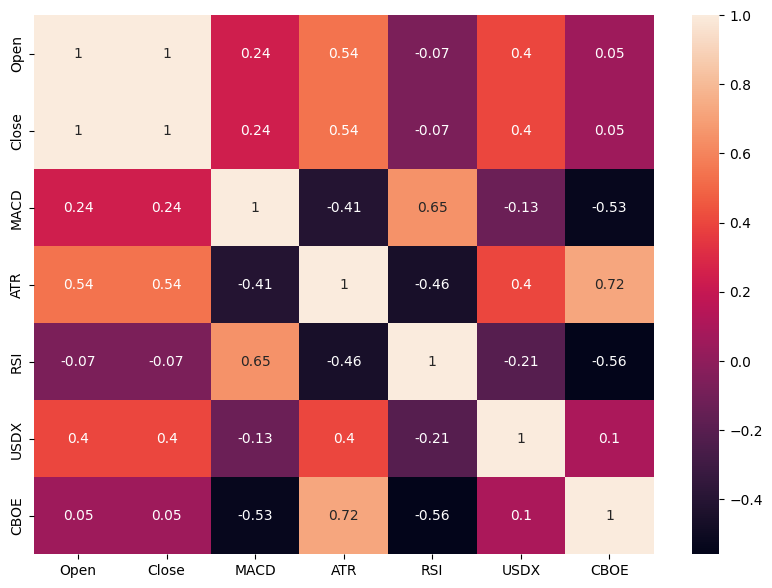

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
df_corr = df.corr().round(2)
sns.heatmap(df_corr, annot=True)

In [13]:
df = df.drop("Open", axis=1) # High Correlation
df

,Close,MACD,ATR,RSI,USDX,CBOE
Datetime,,,,,,
2016-03-22,2048.887162,40.618064,20.966599,91.259153,95.650002,14.170000
2016-03-23,2039.080907,39.076284,20.684064,84.540371,96.050003,14.940000
2016-03-24,2039.080907,37.423024,20.130143,84.540371,96.139999,14.740000
2016-03-28,2043.572356,36.059553,19.917704,85.122213,95.940002,15.240000
2016-03-29,2050.701405,35.149071,19.990263,86.021496,95.160004,13.820000
...,...,...,...,...,...,...
2026-02-06,6931.633951,5.319739,78.177272,52.225675,97.629997,20.370001
2026-02-09,6960.081711,8.588181,77.946707,54.633275,96.820000,17.360001
2026-02-10,6942.475913,9.646604,76.001761,52.857892,96.800003,17.790001


### Scaling the data

"The values of input variables vary from one to another; thus, it leads to a high level of variation. For instance, the stock index close price is much higher than the interest rate. More specifically, the standard deviation of the close price is 695.33, which is significantly higher than the standard deviation 1.664 of the interest rate. If the range of one feature varies more widely than the others, most ML algorithms might not perform well. We have implemented a min–max normalization technique for the feature scaling to address this concern." (page 15)

(2489, 1)

In [14]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop("Close", axis=1)
y = df[["Close"]].to_numpy()

X_scaler = MinMaxScaler()
# y_scaler= MinMaxScaler()

X_scaler.fit(X.iloc[:train_size, :])
# y_scaler.fit(y.iloc[:train_size, :])

X = X_scaler.transform(X)
# y = y_scaler.transform(y)

X.shape, y.shape

((2489, 5), (2489, 1))

### Windowing the dataset

In [15]:
X_windowed = []
y_windowed = []

window_size = 15

for i in range(len(X) - window_size):
    row = np.array([[a] for a in X[i:i+window_size]]).reshape(window_size, X.shape[1])
    label = y[i+window_size]

    X_windowed.append(row)
    y_windowed.append(label)

X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)


X_windowed.shape, y_windowed.shape

((2474, 15, 5), (2474, 1))

The shape of `X_windowed` is `(2475, 15, 8)`, meaning that it has 2475 observations, 15 timesteps in each observation, and 8 features per timestep. 

In [16]:
X_train, y_train = X_windowed[:train_size], y_windowed[:train_size]
X_val, y_val = X_windowed[train_size:train_size+val_size], y_windowed[train_size:train_size+val_size]
X_test, y_test = X_windowed[train_size+val_size:], y_windowed[train_size+val_size:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2000, 15, 5), (250, 15, 5), (224, 15, 5), (2000, 1), (250, 1), (224, 1))

## Model Building

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MAPE
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.optimizers import Adam, Adagrad

2026-02-18 22:24:23.798330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-18 22:24:23.860408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 22:24:25.326512: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [18]:
model1 = Sequential()
model1.add(InputLayer(X_train.shape[1:]))
model1.add(LSTM(128))
model1.add(Dense(8, "relu"))
model1.add(Dense(1, "linear"))

mcp = ModelCheckpoint("model1/best_model.keras", save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[mcp])

Epoch 1/50


2026-02-18 22:24:26.808278: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 11894661.0000 - val_loss: 31662426.0000
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 11752362.0000 - val_loss: 31420170.0000
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 11590501.0000 - val_loss: 31112232.0000
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 11387724.0000 - val_loss: 30728894.0000
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 11142748.0000 - val_loss: 30275682.0000
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 10856856.0000 - val_loss: 29750248.0000
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 10533385.0000 - val_loss: 29158808.0000
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 10176213.0000 - val_loss: 28509102.0000
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9789067.0000 - val_loss: 27801088.0000
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9375821.0000 - val_loss: 27046468.0000
Epoch 11/50
63/63 ━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


<Axes: >

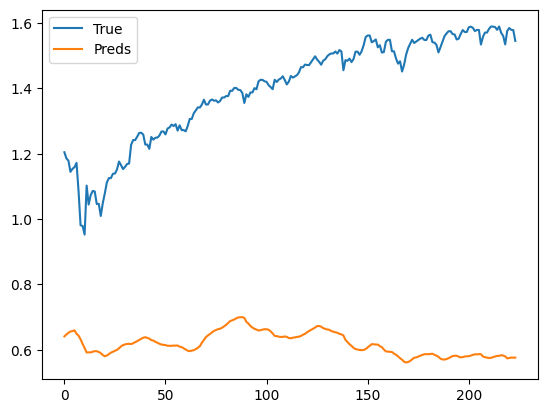

In [76]:
model1_loaded = load_model("model1/best_model.keras")
y_pred = model1_loaded.predict(X_test).flatten()

preds_df = pd.DataFrame({"True": y_test.flatten(), "Preds": y_pred})
preds_df.plot()

ValueError: could not broadcast input array from shape (224,) into shape (239,)

In [62]:
model1 = Sequential()
model1.add(InputLayer(X_train.shape[1:]))
model1.add(LSTM(10))
model1.add(Dense(1, "linear"))

model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10)             │           760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771 (3.01 KB)

 Trainable params: 771 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
mcp = ModelCheckpoint("model1/best_model.keras", save_best_only=True)

model1.compile(loss=MeanSquaredError(), optimizer=Adagrad(learning_rate=0.001))
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[mcp], batch_size=8)

Epoch 1/100


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0979 - val_loss: 0.5309
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0701 - val_loss: 0.4404
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0615 - val_loss: 0.4012
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0554 - val_loss: 0.3709
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0506 - val_loss: 0.3488
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0467 - val_loss: 0.3286
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0434 - val_loss: 0.3089
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0406 - val_loss: 0.2962
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0383 - val_loss: 0.2829
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0363 - val_loss: 0.2716
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0347 - val_loss: 0.2622
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [55]:
from tensorflow.keras.models import load_model

model1_loaded = load_model("model1/best_model.keras")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


<Axes: >

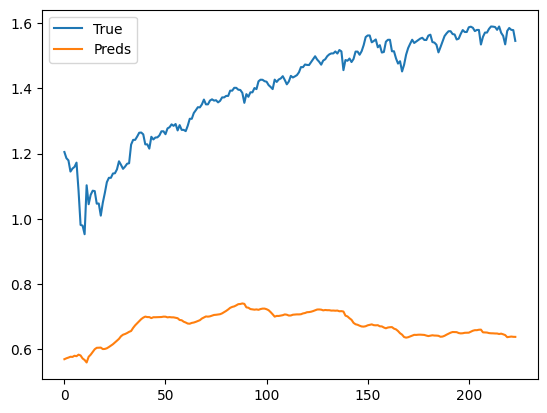

In [56]:
y_pred = model1_loaded.predict(X_test).flatten()

preds_df = pd.DataFrame({"True": y_test.flatten(), "Preds": y_pred})
preds_df.plot()

In [65]:
model2 = Sequential()
model2.add(InputLayer(X_train.shape[1:]))
model2.add(LSTM(10))
model2.add(Dense(1, "linear"))

mcp = ModelCheckpoint("model2/best_model.keras", save_best_only=True)

model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[mcp], batch_size=8)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0683 - val_loss: 0.2003
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0210 - val_loss: 0.1874
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.2334
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.2180
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - val_loss: 0.2064
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063 - val_loss: 0.1884
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045 - val_loss: 0.2187
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - val_loss: 0.2094
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.2171
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.2030
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - val_loss: 0.1916
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


<Axes: >

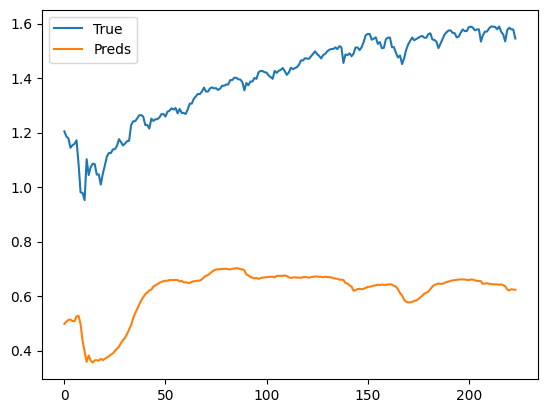

In [67]:
model2_loaded = load_model("model2/best_model.keras")

y_pred = model2_loaded.predict(X_test).flatten()

preds_df = pd.DataFrame({"True": y_test.flatten(), "Preds": y_pred})
preds_df.plot()

In [70]:
model3 = Sequential()
model3.add(InputLayer(X_train.shape[1:]))
model3.add(LSTM(150, return_sequences=True))
model3.add(LSTM(100))
model3.add(Dense(8, "relu"))
model3.add(Dense(1, "linear"))

mcp = ModelCheckpoint("model3/best_model.keras", save_best_only=True)

model3.compile(loss=MeanSquaredError(), optimizer=Adagrad(learning_rate=0.01))
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[mcp], batch_size=8)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0360 - val_loss: 0.2053
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0197 - val_loss: 0.2812
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0180 - val_loss: 0.2343
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0175 - val_loss: 0.2925
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0173 - val_loss: 0.2740
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0169 - val_loss: 0.2499
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0165 - val_loss: 0.2173
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0160 - val_loss: 0.2396
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0158 - val_loss: 0.2550
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0155 - val_loss: 0.2186
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0149 - val_loss: 0.2867
Epoch 12/100
250/250 ━━━━━━━━━

KeyboardInterrupt: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


<Axes: >

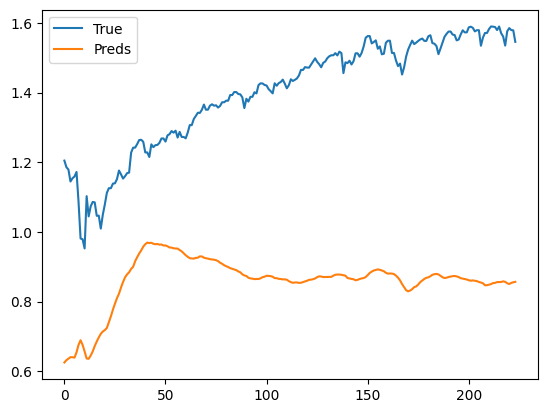

In [71]:
model3_loaded = load_model("model1/best_model.keras")

y_pred = model3_loaded.predict(X_test).flatten()

preds_df = pd.DataFrame({"True": y_test.flatten(), "Preds": y_pred})
preds_df.plot()